In [33]:
# 1. import
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

In [34]:
# 2. download dataset & prepare dataloader
dataset_train = datasets.CIFAR10(root="../../assets/", train=True, download=True,
                                 transform=torchvision.transforms.ToTensor())
dataset_test = datasets.CIFAR10(root="../../assets/", train=False, download=True,
                                transform=torchvision.transforms.ToTensor())

batch_size = 128

train_loader = DataLoader(dataset_train, batch_size=batch_size)
test_loader = DataLoader(dataset_test, batch_size=batch_size)

labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [35]:
# size: batch_size=128, channel=3, height=width=32
imgs, _ = next(iter(train_loader))
imgs.shape

torch.Size([128, 3, 32, 32])

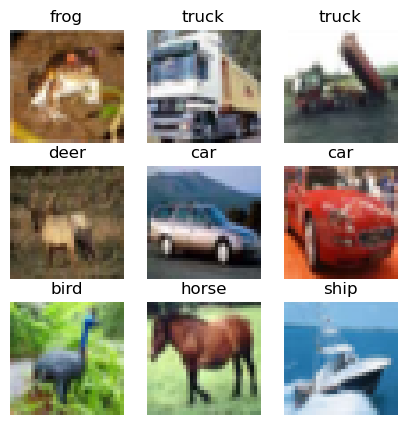

In [37]:
# 3. visualize
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(5, 5))
for i, (x, y) in enumerate(train_loader):
    x = x.permute(0, 2, 3, 1)
    if i == 0:
        for j in range(9):
            idx, idy = int(j / 3), j % 3
            axs[idx][idy].imshow(x[j])
            axs[idx][idy].axis('off')
            axs[idx][idy].set_title(labels[y[j].item()])
    else:
        break

In [38]:
# 4. CNN model
class CifarModel(nn.Module):
    def __init__(self):
        super(CifarModel, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )

        self.dense = nn.Sequential(
            nn.Linear(4 * 4 * 256, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.dense(x)
        return x


model = CifarModel()
print(model)

CifarModel(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense): Sequential(
    (0): Linear(in_features=4096, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [48]:
# 5. params
epochs = 10
learning_rate = 0.001
cost = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [51]:
# train
def train():
    train_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for (i, data) in enumerate(train_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = cost(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            if i % 10 == 0:
                print(f"epoch={epoch},batch={i},loss={loss.item()}")

        train_losses.append(train_loss / len(train_loader))
        print(f"epoch={epoch},loss={train_losses[epoch]}")


train()

epoch=0,batch=0,loss=0.5251115560531616
epoch=0,batch=10,loss=0.9022877216339111


KeyboardInterrupt: 

In [59]:
def test():
    model.eval()
    correct = 0
    for (i, data) in enumerate(test_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        pred = outputs.data.max(1, keepdim=True)[1]
        correct += pred.eq(labels.data.view_as(pred)).sum()
    print(f"accuracy={correct / len(test_loader.dataset)}")
test()

accuracy=0.652899980545044
